# Image features exercise
Мы видели, что мы можем достичь разумной производительности в задаче классификации изображений, обучая линейный классификатор на пикселях входного изображения. В этом упражнении мы покажем, что мы можем улучшить производительность нашей классификации, обучая линейные классификаторы не по необработанным пикселям, а по функциям, которые вычисляются из необработанных пикселей.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
Для каждого изображения мы рассчитаем гистограмму ориентированных градиентов (HOG), а также цветовую гистограмму, используя канал оттенка в цветовом пространстве HSV. Мы формируем наш окончательный вектор признаков для каждого изображения, объединяя векторы признаков HOG и цветовой гистограммы.

Грубо говоря, HOG должен фиксировать текстуру изображения, игнорируя информацию о цвете, а цветовая гистограмма представляет цвет входного изображения, игнорируя текстуру. В результате мы ожидаем, что использование обоих вместе должно работать лучше, чем использование одного отдельно. Проверять это предположение было бы неплохо, если бы вы попробовали в своих интересах.

Функции hog_feature и color_histogram_hsv работают с одним изображением и возвращают вектор признаков для этого изображения. Функция extract_features берет набор изображений и список функций объектов и оценивает каждую функцию объектов на каждом изображении, сохраняя результаты в матрице, где каждый столбец представляет собой объединение всех векторов объектов для одного изображения.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [ 1e-7,1e-6]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

iters = 2000 #100
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs, num_iters=iters, batch_size=200)
        
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (training_accuracy, validation_accuracy)
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\Станислав Карпов\github\Stanford_cs231n\assignment1\cs231n\classifiers\linear_svm.py:145: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
C:\Users\Станислав Карпов\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Станислав Карпов\github\Stanford_cs231n\assignment1\cs231n\classifiers\linear_svm.py:145: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
C:\Users\Станислав Карпов\github\Stanford_cs231n\assignment1\cs231n\classifiers\linear_svm.py:160: RuntimeWarning: overflow encountered in multiply
  dW += reg*W
C:\Users\Станислав Карпов\github\Stanford_cs231n\assignment1\cs231n\classifiers\linear_svm.py:139: RuntimeWarning: invalid value encountered in subtract
  margins = np.maximum(0, scores - correct_class_score + delta)
C:\Users\Станислав Карпов\github\Stanford_cs231n\as

lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.413531 val accuracy: 0.419000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.413020 val accuracy: 0.409000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.381388 val accuracy: 0.386000
lr 1.000000e-06 reg 5.000000e+04 train accuracy: 0.418163 val accuracy: 0.407000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.367265 val accuracy: 0.361000
lr 1.000000e-06 reg 5.000000e+06 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.419000


In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


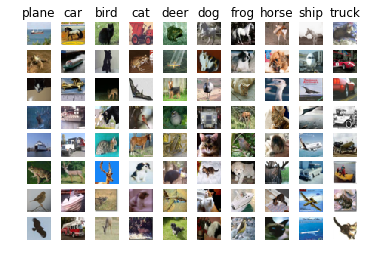

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Ранее в этом задании мы увидели, что при обучении двухслойной нейронной сети на необработанных пикселях достигается лучшая производительность классификации, чем на линейных классификаторах на необработанных пикселях. В этой записной книжке мы видели, что линейные классификаторы по функциям изображений превосходят линейные классификаторы по необработанным пикселям.

Для полноты мы также должны попытаться обучить нейронную сеть особенностям изображения. Этот подход должен превзойти все предыдущие подходы: вы легко сможете достичь более 55% точности классификации на тестовом наборе; наша лучшая модель достигает около 60% точности классификации.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [17]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# logspace - равномерное распределение по логарифмической шкале в заданном интервале
best_val = -1
best_stats = None
results = {} 

learning_rates = np.logspace(-5, 0, 3)

regularization_strengths = [1e-03, 1e-01, 1e+01, 1e+03, 1e+05]

iters = 1000 #100
for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=iters, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=rs)
        
        y_train_pred = net.predict(X_train_feats)
        y_val_pred = net.predict(X_val_feats)
        
        acc_train = np.mean(y_train == y_train_pred)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_train, acc_val)
        
        if best_val < acc_val:
            best_stats = stats
            best_val = acc_val
            best_net = net

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))

print ('best validation accuracy achieved during cross-validation: %f' % best_val)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


lr 1.000000e-05 reg 1.000000e-03 train accuracy: 0.103347 val accuracy: 0.083000
lr 1.000000e-05 reg 1.000000e-01 train accuracy: 0.100551 val accuracy: 0.076000
lr 1.000000e-05 reg 1.000000e+01 train accuracy: 0.103429 val accuracy: 0.095000
lr 1.000000e-05 reg 1.000000e+03 train accuracy: 0.100449 val accuracy: 0.078000
lr 1.000000e-05 reg 1.000000e+05 train accuracy: 0.100041 val accuracy: 0.098000
lr 3.162278e-03 reg 1.000000e-03 train accuracy: 0.100429 val accuracy: 0.079000
lr 3.162278e-03 reg 1.000000e-01 train accuracy: 0.100265 val accuracy: 0.087000
lr 3.162278e-03 reg 1.000000e+01 train accuracy: 0.100265 val accuracy: 0.087000
lr 3.162278e-03 reg 1.000000e+03 train accuracy: 0.100265 val accuracy: 0.087000
lr 3.162278e-03 reg 1.000000e+05 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e+00 reg 1.000000e-03 train accuracy: 0.643122 val accuracy: 0.577000
lr 1.000000e+00 reg 1.000000e-01 train accuracy: 0.390367 val accuracy: 0.376000
lr 1.000000e+00 reg 1.000000

In [18]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.569


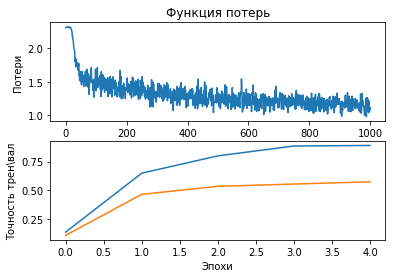

In [26]:
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Функция потерь')
plt.xlabel('Итерация')
plt.ylabel('Потери')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.xlabel('Эпохи')
plt.ylabel('Точность трен\вал')
plt.show()
